<a href="https://colab.research.google.com/github/yonatanlou/notebooks/blob/main/Jaccard_index_for_unsupervised_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jaccard index for unsupervised clustering
TL;DR - Don't use sklearn jaccard_score function when dealing with unsupervised clustering.



The Jaccard Index is a similarity measure used to compare the similarity and diversity of sample sets. It's calculated as the intersection divided by the union of sample sets. While it's a useful metric, its direct application in scikit-learn's `jaccard_score` is not suitable for unsupervised clustering scenarios.

### The Problem with Sklearn's Jaccard Score

Scikit-learn's `jaccard_score` is designed for supervised classification, where the true labels are known. It assumes that the predicted labels correspond directly to the true labels. In unsupervised clustering, however, we don't have ground truth labels. Instead, we have cluster assignments that can be permuted.

For instance, consider two cluster assignments: `[0, 0, 1, 1]` and `[1, 1, 0, 0]`. While these assignments represent the same clustering, the scikit-learn `jaccard_score` would incorrectly report a low similarity.

### Custom Implementation for Unsupervised Clustering

To address this limitation, we can implement a custom Jaccard Index calculation that is agnostic to label permutations:

In [ ]:
def calculate_jaccard_unsupervised(labels_true, labels_pred):
    """
    Calculates the Jaccard index between true and predicted labels without sklearn.

    Args:
        labels_true: True cluster labels.
        labels_pred: Predicted cluster labels.

    Returns:
        Jaccard index.
    """

    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)

    # Create pairwise comparison matrices
    same_in_true = labels_true[:, None] == labels_true[None, :]
    same_in_pred = labels_pred[:, None] == labels_pred[None, :]

    # Calculate intersection and union of the matrices
    intersection = np.logical_and(same_in_true, same_in_pred).sum() - len(labels_true)
    union = np.logical_or(same_in_true, same_in_pred).sum() - len(labels_true)

    return intersection / union if union != 0 else 0.0

This implementation first creates pairwise comparison matrices for both true and predicted labels. Then, it calculates the intersection and union of these matrices, accounting for the fact that cluster labels can be permuted.


First, i will make a function that will simulate data based on number of classes and how simliar those clusters are.


In [36]:
try:
    import umap
except:
    !pip install umap-learn
    import umap

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import LabelBinarizer
from umap import UMAP
import matplotlib as mpl

BACKGROUND_COLOR = "#f5f5f5"
FIGSIZE = (10.5, 3.5)

mpl.rcParams["figure.facecolor"] = BACKGROUND_COLOR
mpl.rcParams["axes.facecolor"] = BACKGROUND_COLOR
mpl.rcParams["savefig.facecolor"] = BACKGROUND_COLOR


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


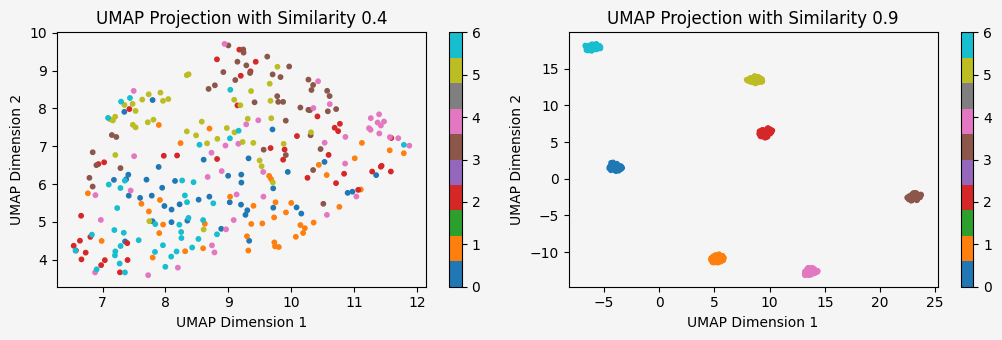

In [37]:

def simulate_data(num_samples, num_features, similarity, num_classes, random_seed=42):
    """
    Generates synthetic data with a certain level of similarity between classes.
    You can implement more complex stuff like distance between clusters, etc.
    """
    np.random.seed(random_seed)

    data = []
    labels = []
    class_centers = np.random.rand(num_classes, num_features)  # Random centers for each class

    for i in range(num_classes):
        # Generate samples around the class center
        class_data = class_centers[i] + np.random.randn(num_samples // num_classes, num_features) * (1 - similarity)
        data.append(class_data)
        labels += [i] * (num_samples // num_classes)

    # Combine data and labels
    data = np.vstack(data)
    labels = np.array(labels)
    return data, labels




def plot_umap_projections(data1, labels1, data2, labels2, num_classes, similarity1, similarity2):
    """
    Reduces both datasets to 2D using UMAP and plots them side by side.
    """
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)

    # UMAP projection for the first dataset
    umap1 = UMAP(n_components=2, random_state=0)
    data1_2d = umap1.fit_transform(data1)
    scatter1 = axes[0].scatter(data1_2d[:, 0], data1_2d[:, 1], c=labels1, cmap="tab10", s=10)
    axes[0].set_title(f"UMAP Projection with Similarity {similarity1}")
    axes[0].set_xlabel("UMAP Dimension 1")
    axes[0].set_ylabel("UMAP Dimension 2")
    plt.colorbar(scatter1, ax=axes[0], ticks=range(num_classes))

    # UMAP projection for the second dataset
    umap2 = UMAP(n_components=2, random_state=0)
    data2_2d = umap2.fit_transform(data2)
    scatter2 = axes[1].scatter(data2_2d[:, 0], data2_2d[:, 1], c=labels2, cmap="tab10", s=10)
    axes[1].set_title(f"UMAP Projection with Similarity {similarity2}")
    axes[1].set_xlabel("UMAP Dimension 1")
    axes[1].set_ylabel("UMAP Dimension 2")
    plt.colorbar(scatter2, ax=axes[1], ticks=range(num_classes))

    plt.tight_layout()
    plt.show()


num_samples = 300
num_features = 10
num_classes = 7


similarity1 = 0.4
data1, labels1 = simulate_data(num_samples, num_features, similarity1, num_classes)

similarity2 = 0.9
data2, labels2 = simulate_data(num_samples, num_features, similarity2, num_classes)

plot_umap_projections(data1, labels1, data2, labels2, num_classes, similarity1, similarity2)

Nice! So we can now control on the similiarity between clusters and the number of clusters.
Let's run a bigger simulation and measure the Jaccard measure:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm


def calculate_jaccard_sklearn(labels_true, labels_pred):
    """
    Calculates the Jaccard index between true and predicted labels using sklearn.
    """
    lb = LabelBinarizer()
    labels_true_bin = lb.fit_transform(labels_true)
    labels_pred_bin = lb.transform(labels_pred)
    return jaccard_score(labels_true_bin, labels_pred_bin, average='weighted')

def calculate_jaccard_unsupervised(labels_true, labels_pred):
    """
    Calculates the Jaccard index between true and predicted labels without sklearn.
    """
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)

    same_in_true = labels_true[:, None] == labels_true[None, :]
    same_in_pred = labels_pred[:, None] == labels_pred[None, :]

    intersection = np.logical_and(same_in_true, same_in_pred).sum() - len(labels_true)
    union = np.logical_or(same_in_true, same_in_pred).sum() - len(labels_true)

    return intersection / union if union != 0 else 0.0



def run_simulation(num_samples, num_features, similarity, class_counts, random_seed=42):
    """
    Runs the simulation for different numbers of classes and calculates both Jaccard indices for each case.
    """
    np.random.seed(random_seed)
    jaccard_sklearn_scores = []
    jaccard_unsupervised_scores = []

    for num_classes in class_counts:
        data, labels_true = simulate_data(num_samples, num_features, similarity, num_classes)

        kmeans = KMeans(n_clusters=num_classes, random_state=random_seed)
        labels_pred = kmeans.fit_predict(data)

        jaccard_sklearn = calculate_jaccard_sklearn(labels_true, labels_pred)
        jaccard_unsupervised = calculate_jaccard_unsupervised(labels_true, labels_pred)

        jaccard_sklearn_scores.append(jaccard_sklearn)
        jaccard_unsupervised_scores.append(jaccard_unsupervised)

    return jaccard_sklearn_scores, jaccard_unsupervised_scores

def run_multiple_simulations(num_samples, num_features, similarity, class_counts, n_runs=10):
    """
    Runs multiple simulations and returns mean and std of the scores.
    """
    sklearn_scores_all = []
    unsupervised_scores_all = []

    for run in tqdm(range(n_runs),desc="simulation"):
        sklearn_scores, unsupervised_scores = run_simulation(
            num_samples, num_features, similarity, class_counts, random_seed=run
        )
        sklearn_scores_all.append(sklearn_scores)
        unsupervised_scores_all.append(unsupervised_scores)

    sklearn_scores_all = np.array(sklearn_scores_all)
    unsupervised_scores_all = np.array(unsupervised_scores_all)

    return {
        'sklearn': {
            'mean': np.mean(sklearn_scores_all, axis=0),
            'std': np.std(sklearn_scores_all, axis=0)
        },
        'unsupervised': {
            'mean': np.mean(unsupervised_scores_all, axis=0),
            'std': np.std(unsupervised_scores_all, axis=0)
        }
    }

# Simulation parameters
num_samples = 10000
num_features = 10
class_counts = list(range(2, 50,2))
similarities = [0.25, 0.5, 0.75, 0.99]
n_runs=10

results = {}
for similarity in tqdm(similarities, desc="Processing similarities"):
    results[similarity] = run_multiple_simulations(
        num_samples=num_samples,
        num_features=num_features,
        similarity=similarity,
        class_counts=class_counts,
        n_runs=n_runs
    )




Processing similarities:   0%|          | 0/4 [00:00<?, ?it/s]

simulation:   0%|          | 0/10 [00:00<?, ?it/s]

simulation:   0%|          | 0/10 [00:00<?, ?it/s]

simulation:   0%|          | 0/10 [00:00<?, ?it/s]

simulation:   0%|          | 0/10 [00:00<?, ?it/s]

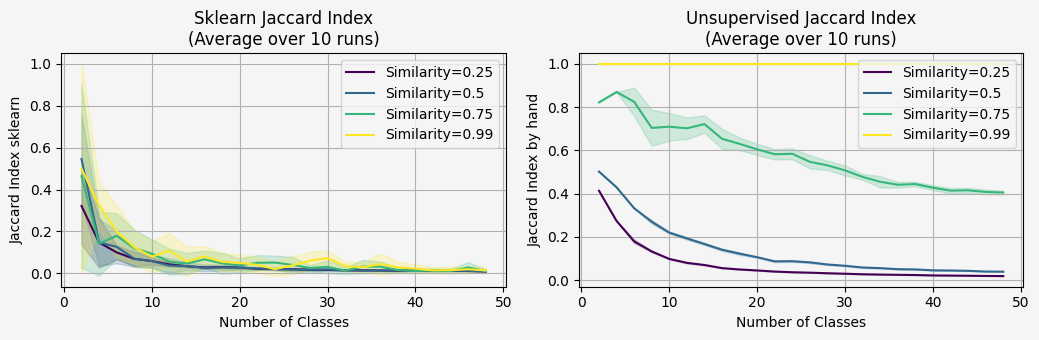

In [38]:
# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE)

colors = plt.cm.viridis(np.linspace(0, 1, len(similarities)))

# Plot sklearn results
for similarity, color in zip(similarities, colors):
    mean = results[similarity]['sklearn']['mean']
    std = results[similarity]['sklearn']['std']
    ax1.plot(class_counts, mean, label=f"Similarity={similarity}", color=color)
    ax1.fill_between(class_counts, mean - std, mean + std, alpha=0.2, color=color)

ax1.set_xlabel("Number of Classes")
ax1.set_ylabel("Jaccard Index sklearn")
ax1.set_title(f"Sklearn Jaccard Index\n(Average over {n_runs} runs)")
ax1.legend()
ax1.grid(True)

# Plot unsupervised results
for similarity, color in zip(similarities, colors):
    mean = results[similarity]['unsupervised']['mean']
    std = results[similarity]['unsupervised']['std']
    ax2.plot(class_counts, mean, label=f"Similarity={similarity}", color=color)
    ax2.fill_between(class_counts, mean - std, mean + std, alpha=0.2, color=color)

ax2.set_xlabel("Number of Classes")
ax2.set_ylabel("Jaccard Index by hand")
ax2.set_title(f"Unsupervised Jaccard Index\n(Average over {n_runs} runs)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

What we will expect to see in this simulation?
We will expect the data with high similiarity (clusters more dense), will get higher jaccard score.
Because ive used the same number of samples, with different number of classes, the jaccard will decrease - but we still expect to see the data with the high similiarity with much better jaccard score then the low similiarity.

The left plot it very very noisy, and we can't say if the which data setting is better.
This is make sense, because the sklearn implementation expecting to get prediction labels that correspond the actual labels.

That means that following setting will get 0 jaccard index:
```
from sklearn.metric import jaccard_score
a = [2,2,3,3,3,1,1,0]
b = [1,1,2,2,2,0,0,3]
jaccard_score(a,b,average="weighted")

#0
```
Which is not what we want when we doing unsupervised clustering.

### Conclusion
When evaluating unsupervised clustering algorithms, it's crucial to use metrics that are robust to label permutations. The custom Jaccard Index implementation presented here provides a reliable way to assess the similarity between true and predicted cluster assignments. By understanding the limitations of scikit-learn's jaccard_score in this context, we can make more informed decisions about the performance of our clustering models.

